## PyTorch CEA model
Based on this code: https://github.com/sksq96/pytorch-vae/blob/master/vae-cnn.ipynb

In [1]:
import imageio
from pathlib import Path


def makegif(folder='reconstructed', name='recon_image', ext='jpg'):
    images = []
    for file in sorted([file for file in Path(folder).glob(f'*.{ext}')]):
        images.append(imageio.imread(str(file)))
    imageio.mimsave(f'{name}.gif', images)
    print("Done!")

In [61]:
import time
import types

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torchsummary import summary

from random import randint

from IPython.display import Image
from IPython.core.display import Image, display

debug_vals = types.SimpleNamespace()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [5]:
bs = 16

### Load Data

In [6]:
from matplotlib.image import imread
from extract_patches import *

In [7]:
img_name = 'ESP_011261_1960_RED0_0.IMG'
sample_img = np.asarray(extract_img(f'data/{img_name}'))

sample_img = sample_img[..., np.newaxis]

patches = extract_patches(sample_img, patch_size=256)
images, ids = get_patches_ids(patches, img_name)

# release the memory
del sample_img

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:2575: DecompressionBombWarning: Image size (102400000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


In [8]:
len(images)

1564

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

In [10]:
def imshow(img):
    plt.imshow(np.squeeze(img))

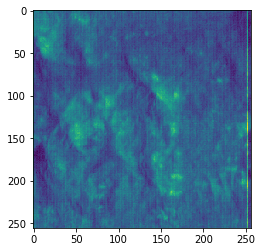

In [11]:
imshow(images[0])

In [12]:
images_matrix = np.stack(images)
del images

# converting to range 0..1 so it can be decoded by sigmoid activation
images_matrix = images_matrix / 255

images_matrix.shape

(1564, 256, 256, 1)

In [13]:
# convert to tensor with dimentions B x H x W x C
# converting to float required by PyTorch
tensor_images = torch.from_numpy(images_matrix).float()

# make the color channel dimension second instead of last
# new dimentions will be B x C x H x W
tensor_images = tensor_images.permute(0, 3, 1, 2)

del images_matrix

In [14]:
tensor_images.size()

torch.Size([1564, 1, 256, 256])

In [15]:
dataset = torch.utils.data.TensorDataset(tensor_images)
loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=bs
)

## Model

In [57]:
class ConvAutoencoder(nn.Module):
    def __init__(self, image_channels=1):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 100, kernel_size=5, stride=1, padding=2), # 100 5x5 filters. padding = 'same'
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(100, 200, kernel_size=5, stride=1, padding=2), # 200 5x5 filters. padding = 'same'
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(200, 100, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(100, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = ConvAutoencoder().to(device)
summary(model, (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 100, 256, 256]           2,600
              ReLU-2        [-1, 100, 256, 256]               0
         MaxPool2d-3        [-1, 100, 128, 128]               0
            Conv2d-4        [-1, 200, 128, 128]         500,200
              ReLU-5        [-1, 200, 128, 128]               0
         MaxPool2d-6          [-1, 200, 64, 64]               0
   ConvTranspose2d-7        [-1, 100, 128, 128]         320,100
              ReLU-8        [-1, 100, 128, 128]               0
   ConvTranspose2d-9          [-1, 1, 256, 256]           1,601
          Sigmoid-10          [-1, 1, 256, 256]               0
Total params: 824,501
Trainable params: 824,501
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.25
Forward/backward pass size (MB): 194.75
Params size (MB): 3.15
Estimated

In [58]:
learning_rate = 1e-3

In [59]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=1e-5)

In [62]:
num_epochs = 10

In [ ]:
def train_model():
    model.train()

    for epoch in range(num_epochs):
        for i, (data,) in enumerate(loader):
            data = data.to(device)

            # forward
            output = model(data)

            # compute MSE loss
            loss = criterion(output, data)

            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if i % 2 == 0:
                print(time.strftime('%X') + f': {i} batches processed. loss:{loss.item():.6f}')

        # log
        #if epoch % 10 == 0:
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.item()))

    torch.save(model.state_dict(), './conv_autoencoder.pth')

train_model()

14:25:37: 0 batches processed. loss:0.000332
14:26:05: 2 batches processed. loss:0.000445
14:26:31: 4 batches processed. loss:0.000388
14:26:56: 6 batches processed. loss:0.000252
14:27:20: 8 batches processed. loss:0.000493
14:27:45: 10 batches processed. loss:0.001260
14:28:09: 12 batches processed. loss:0.000199
14:28:34: 14 batches processed. loss:0.000427
14:28:59: 16 batches processed. loss:0.000605
14:29:23: 18 batches processed. loss:0.000180
14:29:47: 20 batches processed. loss:0.000156
14:30:11: 22 batches processed. loss:0.000396
14:30:35: 24 batches processed. loss:0.000204
14:31:00: 26 batches processed. loss:0.000251
14:31:25: 28 batches processed. loss:0.000504
14:31:49: 30 batches processed. loss:0.000216
14:32:14: 32 batches processed. loss:0.000226
14:32:38: 34 batches processed. loss:0.000208
14:33:03: 36 batches processed. loss:0.000409
14:33:28: 38 batches processed. loss:0.000198
14:33:53: 40 batches processed. loss:0.000118
14:34:18: 42 batches processed. loss:0.

### Original image

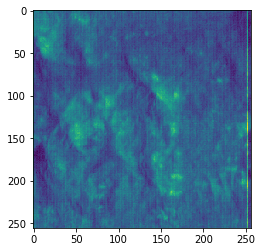

In [43]:
imshow(tensor_images[0:1])

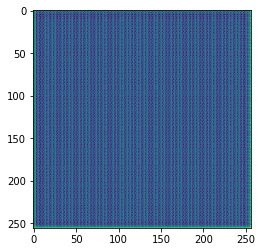

In [42]:
model.eval()
test_data = tensor_images[:1]
test_data = test_data.to(device)

# forward
test_output = model(test_data)

imshow(test_output.data.numpy())

### Training speed
It took 20 mins to run 1 epoch on all patches(~100 batches)

**~12 seconds per batch**